In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 33.6 MB/s 
     |████████████████████████████████| 61 kB 466 kB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apoorvbadar","key":"2919c9fcd1000a004523f4ac9f446ba6"}'}

In [ ]:
from google.colab import files 
upload = files.upload()
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d abee82/fastai-wikitext-wt103-pretrained-model


 93% 192M/206M [00:01<00:00, 147MB/s]
100% 206M/206M [00:01<00:00, 151MB/s]


In [ ]:
!unzip fastai-wikitext-wt103-pretrained-model.zip

Archive:  fastai-wikitext-wt103-pretrained-model.zip
  inflating: wt103-bwd/itos_wt103.pkl  
  inflating: wt103-bwd/lstm_bwd.pth  
  inflating: wt103-fwd/itos_wt103.pkl  
  inflating: wt103-fwd/lstm_fwd.pth  


In [ ]:
!kaggle datasets download -d jcblaise/imdb-sentiments


 76% 28.0M/36.9M [00:00<00:00, 133MB/s]
100% 36.9M/36.9M [00:00<00:00, 122MB/s]


In [ ]:
!unzip imdb-sentiments.zip

Archive:  imdb-sentiments.zip
  inflating: test.csv                
  inflating: test.txt                
  inflating: train.csv               
  inflating: train.txt               
  inflating: valid.txt               


In [ ]:
import utils

ModuleNotFoundError: ignored

In [ ]:
 os.getcwd() 

In [ ]:
class args:
  path = '/content'
  train='train.txt' 
  valid='valid.txt' 
  test='test.txt' 
  output='imdb_finetuned_part' 
  bs=70 
  eval_bs = 10


  bptt=70 
  use_var_bptt = False
  rebuild_dataset = False

  epochs=10 
  tie_weights = True
  load_vocab = True
  vocab_file='vocab_obj.pth'
  save_vocab = True
  encoder = 'awd_lstm'
  decoder = 'dropoutLinear'
  emb_dim = 400
  hidden_dim = 1152
  num_layers = 3
  emb_dp = 0.1
  hidden_dp = 0.3
  input_dp = 0.3
  weight_dp = 0.5
  out_dp = 0.4
  initrange = 0.05
  tie_weights = False
  dm = 1
  use_pretrained = True 
  epochs = 2
  clip = 0.25
  alpha = 2.0
  beta = 1.0
  anneal_factor = 4
  no_warmup = False
  warmup_pct = 0.1
  disc_rate = 1.0

  no_cuda = False

  pretrained_file='wt103-fwd/lstm_fwd.pth' 
  freeze_encoder = True
  optimizer= 'adam' 
  no_lr_scaling =  True
  lr=1e-2 
  gpu=0
  save_graphs = True
  seed = 42



In [ ]:
files.upload()

In [ ]:
device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and not args.no_cuda else 'cpu')
print(device)

NameError: ignored

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from io import open
import hashlib
import argparse

from transformers import get_linear_schedule_with_warmup
from layers import RNNModel, AWDLSTMEncoder, DropoutLinearDecoder, LSTMEncoder, LinearDecoder
from utils import count_parameters, get_loaders, drop_mult
from data import Corpus, Dictionary





if args.decoder == 'dropoutlinear': assert args.encoder == 'awd_lstm'

# CUDA
device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and not args.no_cuda else 'cpu')
np.random.seed(args.seed)
torch.manual_seed(args.seed);
torch.cuda.manual_seed(args.seed);
torch.backends.cudnn.deterministic = True
print("Using device: {}".format(device))

# Produce or load the dataset
path = args.path
fn = '{}/corpus.{}.data'.format(path, hashlib.md5(path.encode()).hexdigest())
if os.path.exists(fn) and not args.rebuild_dataset:
    print('Loading cached dataset...')
    corpus = torch.load(fn)
else:
    print('Producing dataset...')
    if args.load_vocab:
        print('Vocabulary has been loaded from {}'.format(args.vocab_file))
    corpus = Corpus(path, args.train, args.valid, args.test, load_vocab=args.load_vocab, vocab_file=args.vocab_file)
    torch.save(corpus, fn)
    if args.save_vocab:
        with open('{}/{}'.format(path, args.vocab_file), 'wb') as f:
            torch.save([corpus.dictionary.word2idx, corpus.dictionary.idx2word], f)
    
vocab_sz = len(corpus.dictionary)

# Produce dataloaders
train_loader = get_loaders(corpus.train, args.bs, args.bptt, use_var_bptt=args.use_var_bptt)
valid_loader = get_loaders(corpus.valid, args.eval_bs, args.bptt)
test_loader = get_loaders(corpus.test, args.eval_bs, args.bptt)

# Construct encoder

encoder = AWDLSTMEncoder(vocab_sz=vocab_sz, emb_dim=args.emb_dim, hidden_dim=args.hidden_dim, 
                             num_layers=args.num_layers, emb_dp=args.emb_dp, weight_dp=args.weight_dp, 
                             input_dp=args.input_dp, hidden_dp=args.hidden_dp, tie_weights=args.tie_weights)



decoder = DropoutLinearDecoder(hidden_dim=args.emb_dim if args.tie_weights else args.hidden_dim, 
                                   vocab_sz=vocab_sz, out_dp=args.out_dp)

# Produce model
model = RNNModel(encoder, decoder, tie_weights=args.tie_weights, initrange=args.initrange)
model = drop_mult(model, dm=args.dm)
if args.freeze_encoder:
    model.freeze()
    model.unfreeze(-1)
print(model)

# Pretrained
if args.use_pretrained:
    print("Using pretrained model {}".format(args.pretrained_file))
    with open('{}/{}'.format(path, args.pretrained_file), 'rb') as f:
        inc = model.load_state_dict(torch.load(f, map_location=device), strict=False)
    print(inc)
    
model = model.to(device);

# Parameter groups
p_groups = [{'name': '0', 'params': []}, {'name': '1', 'params': []}]
for n, p in model.named_parameters():
    if 'rnn' in n:
        p_groups[1]['params'].append(p)
    else:
        p_groups[0]['params'].append(p)

# Optimization setup
criterion = nn.CrossEntropyLoss()
optimizer, scheduler = None, None
if args.optimizer == 'sgd':
    optimizer = optim.SGD(p_groups, lr=args.lr)
elif args.optimizer == 'adam':
    optimizer = optim.Adam(p_groups, lr=args.lr)
    steps = len(train_loader) * args.epochs
    if not args.no_warmup:
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(steps * args.warmup_pct), num_training_steps=steps)

print("Optimization settings:")
print(optimizer)
print("Scheduler: {}".format(scheduler))
print("The model has {:,} trainable parameters".format(count_parameters(model)))

# Training setup
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

# Training!
print("Beginning training")
try:
    for e in range(1, args.epochs + 1):
        model.train()
        model.reset_hidden()
        train_loss = 0
        with tqdm(total=len(train_loader)) as t:
            for batch in train_loader:
                x, y = batch

                # Scale learning rate to sequence length
                if args.use_var_bptt and not args.no_lr_scaling:
                    seq_len, _ = x.shape
                    optimizer.param_groups[0]['lr'] = args.lr * seq_len / args.bptt

                # Adjust discriminative learning rates
                for i in range(len(optimizer.param_groups)):
                    optimizer.param_groups[i]['lr'] /= args.disc_rate ** i

                x = x.to(device)
                y = y.to(device)

                out = model(x, return_states=True)
                if args.encoder == 'awd_lstm': out, hidden, raw_out, dropped_out = out
                raw_loss = criterion(out.view(-1, vocab_sz), y)

                # AR/TAR
                loss = raw_loss
                if args.encoder == 'awd_lstm':
                    loss += args.alpha * dropped_out[-1].pow(2).mean()
                    loss += args.beta * (raw_out[-1][1:] - raw_out[-1][:-1]).pow(2).mean()

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), args.clip)
                optimizer.step()
                t.set_postfix({'lr{}'.format(i): optimizer.param_groups[i]['lr'] for i in range(len(optimizer.param_groups))})
                if scheduler is not None: scheduler.step()

                # Restore original LR
                if args.use_var_bptt and not args.no_lr_scaling:
                    optimizer.param_groups[0]['lr'] = args.lr

                t.update()
                train_loss += raw_loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        model.reset_hidden()
        valid_loss = 0
        for batch in tqdm(valid_loader):
            with torch.no_grad():
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                out = model(x)
                loss = criterion(out.view(-1, vocab_sz), y)

                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Track and anneal LR
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = e
            print("Best loss so far. Saving model.")
            with open('{}/{}.pth'.format(path, args.output), 'wb') as f:
                torch.save(model.state_dict(), f)
        else:
            if not args.use_var_bptt and not args.no_lr_scaling:
                optimizer.param_groups[0]['lr'] /= args.anneal_factor
        cur_lr = optimizer.param_groups[0]['lr']

        print("Epoch {:3} | Train Loss {:.4f} | Train Ppl {:.4f} | Valid Loss {:.4f} | Valid Ppl {:.4f} | LR {:.4f}".format(e, train_loss, np.exp(train_loss), valid_loss, np.exp(valid_loss), cur_lr))

except KeyboardInterrupt:
    print("Exiting training early")

# Load best saved model
print("Loading best model")
with open('{}/{}.pth'.format(path, args.output), 'rb') as f:
    model.load_state_dict(torch.load(f))

# Testing evaluation
print("Evaluating model")
model.eval()
model.reset_hidden()
test_loss = 0
for batch in tqdm(test_loader):
    with torch.no_grad():
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        loss = criterion(out.view(-1, vocab_sz), y)

        test_loss += loss.item()
test_loss /= len(test_loader)

print("Test Loss {:.4f} | Test Ppl {:.4f}".format(test_loss, np.exp(test_loss)))

# Saving graphs
if args.save_graphs:
    print("Saving loss data")
    pd.DataFrame(data={'train': train_losses, 'valid': valid_losses}).to_csv('{}/{}.csv'.format(path, args.output), index=False)
    with open('{}/{}.txt'.format(path, args.output), 'w') as f:
        f.write("Best loss {:.4f} | Best ppl {:.4f} | Epoch {} | Test loss {:.4f} | Test ppl {:.4f}".format(best_loss, np.exp(best_loss), best_epoch, test_loss, np.exp(test_loss)))


ModuleNotFoundError: ignored

In [ ]:
with open('{}/{}.pth'.format(path, args.output), 'wb') as f:
                torch.save(model.state_dict(), f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp imdb_finetuned_part.pth /content/drive/MyDrive

# Training Loss and Validation Loss

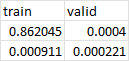